In [1]:
!pip install gensim

In [2]:
!pip freeze | grep gensim

gensim==4.3.3


In [3]:
!pip freeze | grep tensorflow

tensorflow==2.19.0
tensorflow-datasets==4.9.9
tensorflow-hub==0.16.1
tensorflow-metadata==1.17.2
tensorflow-probability==0.25.0
tensorflow-text==2.19.0
tensorflow_decision_forests==1.12.0


In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.metrics import accuracy_score

# (1) Your first embedding

## The data

In [ ]:
def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.AXVUP9_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.AXVUP9_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.AXVUP9_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print(y_train[0], X_train[0])

print(y_test[10], X_test[10])

0 ['this', 'was', 'an', 'absolutely', 'terrible', 'movie', "don't", 'be', 'lured', 'in', 'by', 'christopher', 'walken', 'or', 'michael', 'ironside', 'both', 'are', 'great', 'actors', 'but', 'this', 'must', 'simply', 'be', 'their', 'worst', 'role', 'in', 'history', 'even', 'their', 'great', 'acting', 'could', 'not', 'redeem', 'this', "movie's", 'ridiculous', 'storyline', 'this', 'movie', 'is', 'an', 'early', 'nineties', 'us', 'propaganda', 'piece', 'the', 'most', 'pathetic', 'scenes', 'were', 'those', 'when', 'the', 'columbian', 'rebels', 'were', 'making', 'their', 'cases', 'for', 'revolutions', 'maria', 'conchita', 'alonso', 'appeared', 'phony', 'and', 'her', 'pseudo', 'love', 'affair', 'with', 'walken', 'was', 'nothing', 'but', 'a', 'pathetic', 'emotional', 'plug', 'in', 'a', 'movie', 'that', 'was', 'devoid', 'of', 'any', 'real', 'meaning', 'i', 'am', 'disappointed', 'that', 'there', 'are', 'movies', 'like', 'this', 'ruining', "actor's", 'like', 'christopher', "walken's", 'good', 'nam

In [ ]:
# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)

# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [ ]:
sentence_number = 100

input_raw = X_train[sentence_number]
input_token = X_train_token[sentence_number]

for i in range(40):
  print(f'Word : {input_raw[i]} -> Token {input_token[i]}')

Word : i -> Token 9
Word : enjoyed -> Token 579
Word : this -> Token 11
Word : movie -> Token 18
Word : and -> Token 3
Word : after -> Token 104
Word : watching -> Token 155
Word : it -> Token 10
Word : it -> Token 10
Word : made -> Token 90
Word : me -> Token 65
Word : wonder -> Token 574
Word : just -> Token 40
Word : how -> Token 84
Word : many -> Token 107
Word : 'caitlin -> Token 17238
Word : rose's' -> Token 17239
Word : exist -> Token 1632
Word : in -> Token 8
Word : the -> Token 1
Word : world -> Token 189
Word : how -> Token 84
Word : many -> Token 107
Word : other -> Token 82
Word : girls -> Token 526
Word : have -> Token 25
Word : been -> Token 76
Word : subjected -> Token 5574
Word : to -> Token 5
Word : this -> Token 11
Word : sort -> Token 406
Word : of -> Token 4
Word : sexual -> Token 991
Word : abuse -> Token 2393
Word : and -> Token 3
Word : torment -> Token 8200
Word : by -> Token 31
Word : classmates -> Token 7069
Word : and -> Token 3
Word : have -> Token 25


In [ ]:
vocab_size = len(tokenizer.word_index)

print(f'There are {vocab_size} different words in the train set')

There are 30419 different words in the train set


In [ ]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post')

## The RNN

In [ ]:
embedding_dimension = 50

def init_model():
  model = Sequential()
  model.add(Input(shape=X_train_pad.shape[1:]))

  model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dimension, mask_zero=True))

  model.add(layers.LSTM(units=20, activation='tanh'))
  model.add(layers.Dense(10, activation='relu'))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

model = init_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1164, 50)       │     1,521,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,526,901 (5.82 MB)

 Trainable params: 1,526,901 (5.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f'Expected number of parameters in Embedding layer : {(vocab_size + 1) * embedding_dimension}')

Expected number of parameters in Embedding layer : 1521000


In [18]:
es = EarlyStopping(patience=4, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, batch_size=16, epochs=20, validation_split=0.3, callbacks=[es], verbose=1)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5097 - loss: 0.6924 - val_accuracy: 0.6373 - val_loss: 0.6815
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6884 - loss: 0.6402 - val_accuracy: 0.6307 - val_loss: 0.6433
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8544 - loss: 0.4014 - val_accuracy: 0.7627 - val_loss: 0.4847
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9152 - loss: 0.2522 - val_accuracy: 0.7880 - val_loss: 0.5243
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9530 - loss: 0.1389 - val_accuracy: 0.7773 - val_loss: 0.5405
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9764 - loss: 0.0734 - val_accuracy: 0.8213 - val_loss: 0.4858
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9871 - loss: 0.0438 - val_accuracy: 0.8187 - val_loss: 0.5617


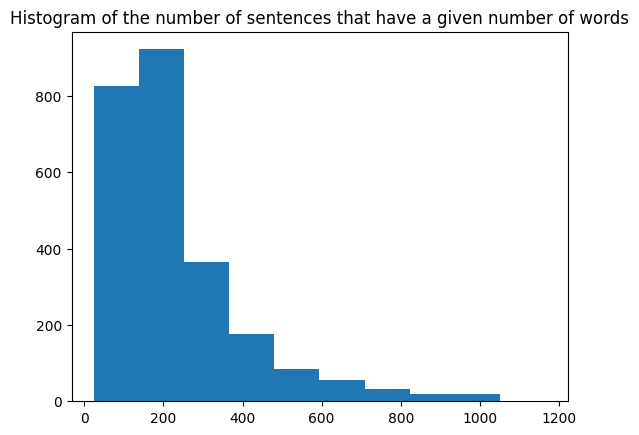

In [20]:
def plot_hist(X):
  len_ = [len(_) for _ in X]
  plt.hist(len_)
  plt.title('Histogram of the number of sentences that have a given number of words')
  plt.show()

plot_hist(X_train)

In [21]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen=200)

history = model.fit(X_train_pad, y_train, epochs=20, batch_size=16, validation_split=0.3, callbacks=[es])

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9287 - loss: 0.2265 - val_accuracy: 0.7947 - val_loss: 0.4526
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9608 - loss: 0.1365 - val_accuracy: 0.8160 - val_loss: 0.4563
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9814 - loss: 0.0743 - val_accuracy: 0.6627 - val_loss: 1.2385
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9864 - loss: 0.0456 - val_accuracy: 0.8200 - val_loss: 0.5574
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9953 - loss: 0.0226 - val_accuracy: 0.8293 - val_loss: 0.6617


# (2) Understand Embeddings with Word2Vec

## The data

In [6]:
def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

## Embedding with Word2Vec

In [8]:
word2vec = Word2Vec(sentences=X_train)
wv = word2vec.wv

In [14]:
wv['hello']

array([-0.05411118,  0.09293313, -0.00452806,  0.0995867 , -0.0203349 ,
       -0.12161584,  0.07601519,  0.23688383, -0.0792779 , -0.12773475,
       -0.04268438, -0.16341233, -0.00859666,  0.04543212, -0.00051293,
       -0.05396463,  0.05485623, -0.04554424, -0.04658214, -0.1757725 ,
       -0.00962551,  0.02363557,  0.12966439, -0.07784718,  0.03059227,
        0.02262719, -0.09832808, -0.07978089, -0.14236526, -0.02659392,
        0.10365185,  0.02877046,  0.01314811, -0.1462989 , -0.06017077,
        0.12868567,  0.07961778, -0.01736611, -0.11510068, -0.12373195,
       -0.0753152 , -0.04122253, -0.10390171,  0.04616684,  0.12347506,
       -0.05919099, -0.02544888, -0.03514903,  0.13048634,  0.06923928,
        0.02612132, -0.18018752, -0.08867496, -0.01366309, -0.13343415,
        0.08368654,  0.07475501, -0.00525051, -0.07074712,  0.0550684 ,
        0.10921293, -0.01215382,  0.01942975,  0.03504094, -0.13416672,
        0.13681705, -0.05906613,  0.04523706, -0.21207531,  0.09

In [16]:
size = len(wv['cat'])

print(f'The embedding space is of size {size}')

The embedding space is of size 100


In [20]:
wv.most_similar("home")

[('run', 0.9575271010398865),
 ('head', 0.9373214840888977),
 ('decides', 0.9324151277542114),
 ('inability', 0.9293957948684692),
 ('knocks', 0.928380012512207),
 ('boyfriend', 0.9278603792190552),
 ('sent', 0.9232490062713623),
 ('down', 0.9211903214454651),
 ('bed', 0.9163027405738831),
 ('dad', 0.9155445098876953)]

In [21]:
word_embedding = wv['car']
wv.similar_by_vector(word_embedding)

[('car', 1.0),
 ('floor', 0.9829575419425964),
 ('prison', 0.9817950129508972),
 ('room', 0.9813856482505798),
 ('government', 0.9785067439079285),
 ('beast', 0.9771414399147034),
 ('church', 0.9769512414932251),
 ('gradually', 0.9764000177383423),
 ('cat', 0.9746506214141846),
 ('battle', 0.9742656350135803)]

## Arithmetic on words

In [22]:
wv['good'] - wv['bad']

array([-0.10050958, -0.2675174 ,  0.11039907,  0.17861044,  0.03025866,
       -0.32976127, -0.29410392,  0.18608402, -0.08707345, -0.2960074 ,
       -0.00693513,  0.36086154,  0.20400003, -0.13719022, -0.04520494,
        0.20783012, -0.32658547,  0.16491377, -0.27812165,  0.2562865 ,
       -0.07223833, -0.20411134, -0.1259458 , -0.11009485, -0.01965491,
       -0.11201039, -0.3256417 ,  0.5442155 ,  0.0432941 , -0.5391721 ,
       -0.5697312 ,  0.04468288, -0.00894392,  0.18980774, -0.0465734 ,
       -0.08078337,  0.50303864, -0.5181436 , -0.47953296,  0.5997958 ,
       -0.42217332, -0.18044008, -0.3785874 , -0.17202926,  0.38492244,
       -0.4015174 ,  0.32032937, -0.28982565, -0.08872631,  0.3881725 ,
       -0.23663841, -0.29839945, -0.34148154, -0.01265097,  0.09239408,
        0.27203697,  0.15092778,  0.04910821,  0.19701198,  0.38661253,
        0.17915256,  0.05486888, -0.35234922, -0.39114678,  0.17615688,
       -0.06371057, -0.28855324, -0.27955392,  0.530362  ,  0.43

In [23]:
res = wv['good'] - wv['bad'] + wv['stupid']

In [24]:
wv.similar_by_vector(res)

[('good', 0.7914219498634338),
 ('nice', 0.787574827671051),
 ('great', 0.786125898361206),
 ('potential', 0.7718981504440308),
 ('decent', 0.7599413990974426),
 ('also', 0.7532753348350525),
 ('criticized', 0.7491025924682617),
 ('given', 0.743895411491394),
 ('smart', 0.7398479580879211),
 ('known', 0.7391011118888855)]

In [25]:
res = wv['queen'] - wv['king'] + wv['actor']
wv.similar_by_vector(res)

[('actor', 0.9730684161186218),
 ('performance', 0.8594101071357727),
 ('job', 0.8528802394866943),
 ('actress', 0.8517615795135498),
 ('role', 0.8395037651062012),
 ('guy', 0.79451984167099),
 ('character', 0.7805243730545044),
 ('man', 0.7641109824180603),
 ('psychic', 0.7529674768447876),
 ('woman', 0.7396280169487)]

## Word2Vec hyperparameters

The arguments you have seen (`vector_size`, `min_count` and `window`) are usually the ones that you should start playing with to get a better performance for your model.

In [26]:
word2vec_2 = Word2Vec(sentences=X_train, vector_size=50)
wv2 = word2vec_2.wv
len(wv2['movie'])

50

In [27]:
print('Vocabulary size', len(wv2.key_to_index))

diff_words = set([_ for elt in X_train for _ in elt])
print('Number of different words in the train set', len(diff_words))

Vocabulary size 8006
Number of different words in the train set 30419


In [28]:
word2vec_3 = Word2Vec(sentences=X_train, vector_size=50, min_count=40)
word2vec_4 = Word2Vec(sentences=X_train, vector_size=50, min_count=2)

print(f'Number of word in W2V #1 : {len(wv.key_to_index)}')
print(f'Number of word in W2V #2 : {len(wv2.key_to_index)}')
print(f'Number of word in W2V #3 : {len(word2vec_3.wv.key_to_index)}')
print(f'Number of word in W2V #4 : {len(word2vec_4.wv.key_to_index)}')

Number of word in W2V #1 : 8006
Number of word in W2V #2 : 8006
Number of word in W2V #3 : 1385
Number of word in W2V #4 : 16729


In [29]:
word2vec_5 = Word2Vec(sentences=X_train, vector_size=50, min_count=40, window=10)

## Convert our train and test set to RNN-ready datasets

In [32]:
example = ['this', 'movie', 'is', 'the', 'worst', 'action', 'movie', 'ever']
example_missing_words = ['this', 'movie', 'is', 'laaaaaaaaaame']

def embed_sentence(word2vec, sentence):
  embedded_sentence = []
  for word in sentence:
    if word in word2vec.wv:
      embedded_sentence.append(word2vec.wv[word])

  return np.array(embedded_sentence)

# Checks
embedded_sentence = embed_sentence(word2vec, example)
assert(type(embedded_sentence) == np.ndarray)
assert(embedded_sentence.shape == (8, 100))

embedded_sentence_missing_words = embed_sentence(word2vec, example_missing_words)
assert(type(embedded_sentence_missing_words) == np.ndarray)
assert(embedded_sentence_missing_words.shape == (3, 100))

In [33]:
def embedding(word2vec, sentences):
  embed = []

  for sentence in sentences:
    embedded_sentence = embed_sentence(word2vec, sentence)
    embed.append(embedded_sentence)

  return embed

X_train_embedded = embedding(word2vec, X_train)
X_test_embedded = embedding(word2vec, X_test)

In [34]:
X_train_pad = pad_sequences(X_train_embedded, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_embedded, dtype='float32', padding='post')

assert(len(X_train_pad.shape) == 3)
assert(len(X_test_pad.shape) == 3)
assert(X_train_pad.shape[2] == 100)
assert(X_test_pad.shape[2] == 100)

# (3) Sentiment Analysis with Word2Vec

## The data

In [45]:
def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=25)

In [46]:
word2vec = Word2Vec(sentences=X_train, vector_size=60, min_count=10, window=10)

In [47]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
  embedded_sentence = []
  for word in sentence:
    if word in word2vec.wv:
      embedded_sentence.append(word2vec.wv[word])

  return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
  embed = []

  for sentence in sentences:
    embedded_sentence = embed_sentence(word2vec, sentence)
    embed.append(embedded_sentence)

  return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

In [48]:
# TEST ME
for X in [X_train_pad, X_test_pad]:
  assert type(X) == np.ndarray
  assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

## Baseline Model

In [49]:
unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print('Number of labels in train set', counts)

y_pred = 0 if counts[0] > counts[1] else 1

print('Baseline accuracy: ', accuracy_score(y_test, [y_pred]*len(y_test)))

Number of labels in train set {0: 3118, 1: 3132}
Baseline accuracy:  0.49504


## The model

In [50]:
def init_model():
  model = Sequential()
  model.add(layers.Masking())
  model.add(layers.LSTM(20, activation='tanh'))
  model.add(layers.Dense(15, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

model = init_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, batch_size=32, epochs=100, validation_split=0.3, callbacks=[es], verbose=1)

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5661 - loss: 0.6841 - val_accuracy: 0.6096 - val_loss: 0.6594
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6594 - loss: 0.6220 - val_accuracy: 0.6864 - val_loss: 0.5929
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7359 - loss: 0.5415 - val_accuracy: 0.7376 - val_loss: 0.5368
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7611 - loss: 0.4982 - val_accuracy: 0.7643 - val_loss: 0.5109
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7705 - loss: 0.4791 - val_accuracy: 0.7611 - val_loss: 0.5046
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7922 - loss: 0.4653 - val_accuracy: 0.7685 - val_loss: 0.5031
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7987 - loss: 0.4436 - val_accuracy: 0.7632 - val_loss: 0.5013
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7965 - loss: 0.4419 - 

In [52]:
res = model.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7819 - loss: 0.4859
The accuracy evaluated on the test set is of 78.016%


## Trained Word2Vec - Transfer Learning

In [54]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [67]:
word2vec_transfer = api.load("glove-wiki-gigaword-200")

[==================================================] 100.0% 252.1/252.1MB downloaded


In [68]:
print(len(word2vec_transfer.key_to_index))
print(len(word2vec_transfer['hello']))

400000
200


In [69]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
  embedded_sentence = []
  for word in sentence:
    if word in word2vec:
      embedded_sentence.append(word2vec[word])

  return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
  embed = []

  for sentence in sentences:
    embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
    embed.append(embedded_sentence)

  return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

In [70]:
# Pad the training and test embedded sentences
X_train_pad_2 = pad_sequences(X_train_embed_2, dtype='float32', padding='post', maxlen=500)
X_test_pad_2 = pad_sequences(X_test_embed_2, dtype='float32', padding='post', maxlen=500)

In [71]:
model = init_model()

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, batch_size=32, epochs=100, validation_split=0.3, callbacks=[es], verbose=1)

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5639 - loss: 0.6841 - val_accuracy: 0.5893 - val_loss: 0.6685
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6342 - loss: 0.6422 - val_accuracy: 0.6544 - val_loss: 0.6241
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6821 - loss: 0.5810 - val_accuracy: 0.6891 - val_loss: 0.5899
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7490 - loss: 0.5174 - val_accuracy: 0.6747 - val_loss: 0.6190
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7588 - loss: 0.4916 - val_accuracy: 0.7328 - val_loss: 0.5460
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7800 - loss: 0.4766 - val_accuracy: 0.7573 - val_loss: 0.5187
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7925 - loss: 0.4434 - val_accuracy: 0.7536 - val_loss: 0.5440
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7922 - loss: 0.4474 - 

In [ ]:
res = model.evaluate(X_test_pad_2, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

# (4) Natural Language Processing with ConvNets

## The data

In [5]:
def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

## Part 1: Concatenate a Keras Embedding with a Conv1D

### First, the data

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_token, maxlen=150, dtype='float32')
X_test_pad = pad_sequences(X_test_token, maxlen=150, dtype='float32')

vocab_size = len(tokenizer.word_index)
vocab_size

30419

### Using 1D Convolution

In [7]:
def init_cnn_model(vocab_size):
  model = Sequential()

  model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=10, mask_zero=True, input_length=150))

  model.add(layers.Conv1D(16, 3))
  model.add(layers.Flatten())

  model.add(layers.Dense(5, ))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_cnn = init_cnn_model(vocab_size)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model_cnn.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[es], verbose=1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.5121 - loss: 0.6930 - val_accuracy: 0.5613 - val_loss: 0.6893
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8729 - loss: 0.6254 - val_accuracy: 0.6160 - val_loss: 0.6643
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9461 - loss: 0.3526 - val_accuracy: 0.6813 - val_loss: 0.5987
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9899 - loss: 0.0743 - val_accuracy: 0.7253 - val_loss: 0.5691
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9968 - loss: 0.0229 - val_accuracy: 0.7267 - val_loss: 0.5817
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0088 - val_accuracy: 0.7160 - val_loss: 0.6562
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.7280 - val_loss: 0.6126
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.7293 - val_loss: 0.6176

In [11]:
res = model_cnn.evaluate(X_test_pad, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6701 - loss: 0.6284
The accuracy evaluated on the test set is of 68.720%


## Part 2: Learn a Word2Vec representation, and then feed it into a NN with a Conv1D

In [12]:
# Load a Word2Vec embedding
word2vec_transfer = api.load("glove-wiki-gigaword-50")

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
  embedded_sentence = []
  for word in sentence:
    if word in word2vec:
      embedded_sentence.append(word2vec[word])

  return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
  embed = []

  for sentence in sentences:
    embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
    embed.append(embedded_sentence)

  return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

# Pad the training and test embedded sentences
X_train_pad_2 = pad_sequences(X_train_embed_2, dtype='float32', padding='post', maxlen=200)
X_test_pad_2 = pad_sequences(X_test_embed_2, dtype='float32', padding='post', maxlen=200)

In [13]:
def init_cnn_model_2():
  model = Sequential()
  model.add(layers.Conv1D(16, 3))
  model.add(layers.Flatten())
  model.add(layers.Dense(5,))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model_cnn_2 = init_cnn_model_2()

es_2 = EarlyStopping(patience=5, restore_best_weights=True)

history = model_cnn_2.fit(X_train_pad_2, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[es_2], verbose=1)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5209 - loss: 0.8681 - val_accuracy: 0.5907 - val_loss: 0.7028
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7460 - loss: 0.5232 - val_accuracy: 0.6213 - val_loss: 0.6788
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8451 - loss: 0.3847 - val_accuracy: 0.6267 - val_loss: 0.6948
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8972 - loss: 0.3055 - val_accuracy: 0.6400 - val_loss: 0.7412
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9389 - loss: 0.2287 - val_accuracy: 0.6307 - val_loss: 0.7959
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9613 - loss: 0.1742 - val_accuracy: 0.6213 - val_loss: 0.8973
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9788 - loss: 0.1336 - val_accuracy: 0.6360 - val_loss: 0.9259


In [14]:
res = model_cnn_2.evaluate(X_test_pad_2, y_test, verbose=1)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6145 - loss: 0.7058
The accuracy evaluated on the test set is of 62.120%


# (5) Text generation using a RNN

## Setup

In [45]:
path_to_data = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [46]:
text = open(path_to_data, 'rb').read().decode(encoding='utf-8')

# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## Preprocessing

In [47]:
# Vectorize the text
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [48]:
# Generate the vocab
vocab = sorted(set(text))

In [49]:
ids_from_chars = tf.keras.layers.StringLookup(
  vocabulary=vocab, mask_token=None)

In [50]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [51]:
chars_from_ids = tf.keras.layers.StringLookup(
  vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [52]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [53]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [54]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [55]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [56]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [57]:
sequences = ids_dataset.batch(101, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [58]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [59]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [60]:
dataset = sequences.map(split_input_target)
dataset

<_MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>

In [61]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Optimizing the dataset

In [62]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
  dataset
  .shuffle(BUFFER_SIZE)
  .batch(BATCH_SIZE, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Building the Model

In [70]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, 256)
    self.gru = tf.keras.layers.GRU(1024, return_sequences=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    x = self.gru(x, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [71]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

model = MyModel(vocab_size=vocab_size)

In [72]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [75]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

sampled_indices

array([ 5, 24, 29, 22, 26, 19, 44, 44, 55, 10, 24, 64, 63, 22, 63, 63, 27,
       39, 23, 47, 24,  6,  2, 36, 60, 25, 25,  6, 44,  0, 18,  0, 41, 33,
       43, 42, 23, 28, 21, 61, 22, 19, 54, 56, 56,  2, 19, 42, 54, 46, 65,
       36, 32, 30, 62, 10, 49, 13, 14, 43,  9, 57,  7, 25, 23, 60,  2, 20,
       63, 16,  9,  2,  4, 56, 31, 51, 53, 43, 64, 18, 10,  5, 35,  8, 33,
       36, 26, 27, 65, 35, 10, 62, 27, 25, 47, 34,  2, 12, 27, 12])

## Train the model

In [76]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss)

In [81]:
history = model.fit(dataset, epochs=100)

Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 1.3333
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 1.2826
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 1.2392
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 1.1984
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 1.1543
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 1.1125
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 1.0670
Epoch 8/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 1.0244
Epoch 9/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.9761
Epoch 10/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.9281
Epoch 11/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.8804
Epoch 12/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.8269
Epoch 13/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.7789
Epoch 14/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.7317
Epoch 15/100
17

## Generate text

In [82]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars):
    super().__init__()
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [83]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [84]:
states = None
next_char = tf.constant(['Juliet: Where art thou, Romeo?'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

Juliet: Where art thou, Romeo?
ALIZO:
So-tht, wall hoblldsbe thathe:
I e e'The sisar:

Gedomixfthoud IO!
Anilishescar at:
I I y.


RY aled! oly fius OMomy he pishuld ars me owld bere, gh ate KEThint, thilfu m; athy weingh pt on.
wn k ad s fong whin wle Se, iers: STIFouchthecond in boteatithettape iouesproug, chemaret gugu oum; ch
Berd taprt,

A:
INAbar br ONDonig t r's, m ve, be, at d bl houlinure way
Len br hive y bre, er
TRosta:
HI Tar
G,

T:
Whas! w aghat s, gl ongou apr I in te moupiny mond hiceche s, thar deadere; NI d in w

PE:
Why wiefucure yavilo, t llus
Ar
LO:
Oughoin ind t ho'lins aneare p lling wed be whit winack! a in he
EYop,
INAre, owlie ingot d; omatatoe.


ARKI'llinotrey wnge fr.


HO:
MERI'sofuticelre acendwit ina, stis
wovist wedstif whinanout fl?
ALCUSin irmicheete

MO:
inthmety in ar w y by hes t,
An weer, by, towoutullingot ut Woukie anug, avealet's ot t ychovert omy m'
ind IO:

ALANou iche I t t o, pre


SThelefay, hat g, y boucon finde k.
RY owase,
UCis whathathe